In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

file = '../data/Run000260/data_000000.txt'
run260 = pd.read_csv(file)
run260.drop('HEAD', inplace=True, axis=1)

print(run260.info())
display(run260.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310592 entries, 0 to 1310591
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   FPGA         1310592 non-null  int64
 1   TDC_CHANNEL  1310592 non-null  int64
 2   ORBIT_CNT    1310592 non-null  int64
 3   BX_COUNTER   1310592 non-null  int64
 4   TDC_MEAS     1310592 non-null  int64
dtypes: int64(5)
memory usage: 50.0 MB
None


,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,1.310592e+06,1.310592e+06,1.310592e+06,1.310592e+06,1.310592e+06
mean,6.110017e-01,6.731868e+01,1.917389e+09,1.780785e+03,1.342183e+01
std,4.875231e-01,4.093277e+01,6.613721e+06,1.028466e+03,9.154085e+00
min,0.000000e+00,1.000000e+00,1.897415e+09,0.000000e+00,0.000000e+00
25%,0.000000e+00,3.100000e+01,1.918696e+09,8.910000e+02,5.000000e+00
50%,1.000000e+00,6.800000e+01,1.919401e+09,1.781000e+03,1.300000e+01
75%,1.000000e+00,9.900000e+01,1.920162e+09,2.670000e+03,2.100000e+01
max,1.000000e+00,1.390000e+02,1.920955e+09,3.563000e+03,2.900000e+01


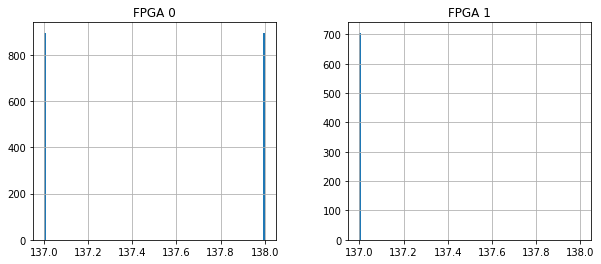

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

df_0 = run260[run260['FPGA']==0]
df_1 = run260[run260['FPGA']==1]

max_channel = run260['TDC_CHANNEL'].max()
df_0.hist('TDC_CHANNEL', ax=ax1, bins=max_channel, range=(137,138))
df_1.hist('TDC_CHANNEL', ax=ax2, bins=max_channel, range=(137,138))
ax1.set_title('FPGA 0')
ax2.set_title('FPGA 1')

plt.show()

In [45]:
from numba import vectorize, int64, jit, njit
# run260['time'] = run260['ORBIT_CNT']*2564*25 + run260['BX_COUNTER']*25 + run260['TDC_MEAS']*25/30
run260['time'] = run260['BX_COUNTER']*25 + run260['TDC_MEAS']*25/30

# Scintillator trigger channel 1 & 2
st1 = 137
st2 = 138
# Mean-time trigger channel
mtt = 139
# params
T_M = 390 # ms
L = 42 # mm
v_d = L/(2*T_M)

# Detector column displays -1 for trigger and detector number else
run260['detector'] = -1
run260.loc[run260['TDC_CHANNEL']<=128,'detector'] = run260['FPGA']*2+1 + run260['TDC_CHANNEL']//64
# add layer column
@vectorize([int64(int64, int64)])
def giveDetector(fpga, channel):
    if channel > 128:
        return -1

    channel -= 1
    return fpga*2 + 1 + channel // 64

@vectorize([int64(int64)])
def giveLayer(channel):
    if channel > 128:
        return -1

    layer_map = {0 : 1,
                 1 : 4,
                 2 : 2,
                 3 : 3}

    cell_index = channel % 64
    layer = layer_map[cell_index % 4]
    
    return layer

@vectorize([int64(int64)])
def giveCell(channel):
    if channel > 128:
        return -1

    channel -= 1
    cell_index = channel % 64
    cell = cell_index // 4 + 1

    return cell

# Test of functions
if __name__ == '__main__':
    first_cell_of_layer = 67
    a = np.arange(first_cell_of_layer,first_cell_of_layer+16*4,4)
    print(list(zip(giveDetector(0,a), giveLayer(a), giveCell(a))))


[(2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 3, 9), (2, 3, 10), (2, 3, 11), (2, 3, 12), (2, 3, 13), (2, 3, 14), (2, 3, 15), (2, 3, 16)]


In [35]:
# run260.groupby('ORBIT_CNT')
run260['detector'] = giveDetector(run260['FPGA'], run260['TDC_CHANNEL'])
run260['layer'] = giveLayer(run260['TDC_CHANNEL'])
run260['cell'] = giveCell(run260['TDC_CHANNEL'])
# display(run260[run260['TDC_CHANNEL']==st1].head())
# display(run260[run260['TDC_CHANNEL']==st2].head())
display(run260.head(5))

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time,detector,layer,cell
0,1,116,1897414884,1533,24,38345.000000,4,1,13
1,1,71,1897414887,1650,21,41267.500000,4,3,2
2,1,67,1897414914,980,8,24506.666667,4,3,1
3,1,70,1897414922,1287,8,32181.666667,4,2,2
4,0,57,1897414922,2162,22,54068.333333,1,4,15


In [36]:
trigger_mtt = run260.loc[run260['TDC_CHANNEL']==mtt, ['ORBIT_CNT','time']]
display(run260.loc[run260['TDC_CHANNEL']==mtt].head())
trigger_st = run260.loc[(run260['TDC_CHANNEL']==st1) | (run260['TDC_CHANNEL']==st2), ['ORBIT_CNT','time']]
trigger_st1 = run260.loc[run260['TDC_CHANNEL']==st1, ['ORBIT_CNT','time']]
display(trigger_mtt.head())
display(trigger_st.head())

,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time,detector,layer,cell
8,0,139,1897414934,2028,0,50700.0,-1,-1,-1
72,0,139,1897415301,2812,0,70300.0,-1,-1,-1
87,1,139,1897415425,1335,0,33375.0,-1,-1,-1
115,1,139,1897415544,1234,0,30850.0,-1,-1,-1
140,1,139,1897415674,1198,0,29950.0,-1,-1,-1


,ORBIT_CNT,time
8,1897414934,50700.0
72,1897415301,70300.0
87,1897415425,33375.0
115,1897415544,30850.0
140,1897415674,29950.0


,ORBIT_CNT,time
24235,1897537507,26853.333333
24238,1897537507,26857.500000
24239,1897537507,26850.833333
24241,1897537507,26860.000000
244487,1918505505,1525.833333


In [142]:
events = run260.loc[run260['ORBIT_CNT'].isin(trigger_mtt['ORBIT_CNT'])]
events = events[events['TDC_CHANNEL'] <= 128]
# events['trigger_time'] = trigger_mtt['time'].reindex(events.index, method='backfill')
changes = (events['ORBIT_CNT'].diff() != 0).cumsum()
events.set_index([changes.to_numpy(), events.index], inplace=True)
# events['trigger_time'] = trigger_mtt['time']
events.rename_axis(('event','index'), inplace=True)
events.sort_values(['event','detector','layer','cell'], inplace=True)
events.drop(['FPGA','TDC_CHANNEL','ORBIT_CNT','BX_COUNTER','TDC_MEAS'], inplace=True, axis=1)

# display(events.loc[55])

,time,detector,layer,cell
index,,,,
5,50360.833333,1,1,6
6,50366.666667,1,2,7
7,50660.833333,1,2,7
10,50609.166667,1,3,7
11,50657.500000,1,4,8
9,50661.666667,1,4,9


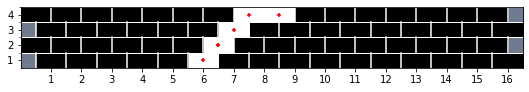

In [124]:
first_event = events.loc[1].copy()

display(first_event)
# first_event['cell'] = [1,1,1,1]

def plot_event(event):
    detector_m = np.zeros((4,16*2+1))

    fig, ax = plt.subplots(figsize=(9,2))

    even_layers = first_event['layer']%2 == 0
    odd_layers = even_layers == False

    def fillDetectorMatrix(matrix, i, j, s=0):
        matrix[i,j*2+s] = 1
        matrix[i,j*2+1+s] = 1

    fillDetectorMatrix(detector_m, first_event.loc[even_layers,'layer']-1,
                first_event.loc[even_layers,'cell']-1, s=0)
    fillDetectorMatrix(detector_m, first_event.loc[odd_layers,'layer']-1,
                first_event.loc[odd_layers,'cell']-1, s=1)

    detector_m[(0,1,2,3),(0,32,0,32)] = 0.5 # Mark "cell offset"

    ax.matshow(detector_m, origin='lower', cmap='bone')
    ax.scatter((first_event.loc[even_layers, 'cell']-1)*2+0.5,
               first_event.loc[even_layers, 'layer']-1, s=10, c='r', marker='+')
    ax.scatter((first_event.loc[odd_layers, 'cell']-1)*2+1.5,
               first_event.loc[odd_layers, 'layer']-1, s=10, c='r', marker='+')

    # Major ticks
    ax.set_xticks(np.arange(1.5, 32, 2));
    ax.set_yticks(np.arange(0, 4, 1));

    # # Labels for major ticks
    ax.set_xticklabels(np.arange(1, 17, 1));
    ax.set_yticklabels(np.arange(1, 5, 1));

    # # Minor ticks
    # # ax.set_xticks(np.arange(-.5, 32, 2), minor=True);
    ax.set_yticks(np.arange(0.5, 4, 1), minor=True);

    ax.grid(which='minor', axis='y', color='w', linewidth=1)
    ax.xaxis.set_ticks_position('bottom')
    
    vert_line = np.array([0,1])
    for l in range(4):
        for c in range(16):
            if l%2 == 0:
                plt.plot([c*2+0.5,c*2+0.5], vert_line+l-0.5, c='w')
            else:
                plt.plot([c*2+1.5,c*2+1.5], vert_line+l-0.5, c='w')

    plt.show()

plot_event(first_event)

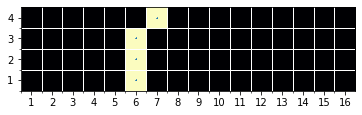

In [39]:
first_event = events.loc[2].copy()
# first_event['time'] = first_event['time'] - first_event['time'].iloc[0]
# first_event['x'] = v_d * first_event['time']
# display(first_event)
# display(events.loc[1])
detector_m = np.zeros((4,16))

fig, ax = plt.subplots()

detector_m[first_event['layer']-1, first_event['cell']-1] = 1
# detector_m[first_event['layer']-1, first_event['cell']-1] = 1
ax.matshow(detector_m, origin='lower', cmap='magma')
ax.xaxis.set_ticks_position('bottom')
ax.scatter(first_event['cell']-1, first_event['layer']-1, 1, marker='+')

# Major ticks
ax.set_xticks(np.arange(0, 16, 1));
ax.set_yticks(np.arange(0, 4, 1));

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 17, 1));
ax.set_yticklabels(np.arange(1, 5, 1));

# Minor ticks
ax.set_xticks(np.arange(-.5, 15, 1), minor=True);
ax.set_yticks(np.arange(-.5, 3, 1), minor=True);

ax.grid(which='minor', axis='both', color='w', linewidth=1)

plt.show()

# Get $t_0$

$$T_{Max} = \frac{(t'_1-t_0)+(t'_3-t_0)}{2}+(t'_2-t_0)$$

$$t_0 = \frac{1}{2}\left(\frac{t'_1+t'_3}{2}+t'_2-T_{Max}\right)$$

In [137]:
display(events.head(10))

def findTrajectories(df):
    for i in events.index.get_level_values(0).unique():
        if events.loc[i,'detector'].nunique() != 1:
            events.drop(i, inplace=True)
            continue

        for l in range(1,4):
            fst_layer = events.loc[(i, events['layer'] == l), 'cell']
            sec_layer = events.loc[(i, events['layer'] == l+1), 'cell']

            # Find predecessor for each cell in layer
            if l % 2 == 0:
                predecessor_mask = sec_layer.isin(fst_layer) | sec_layer.isin(fst_layer-1) # change if drawing not wrong???
            else:
                predecessor_mask = sec_layer.isin(fst_layer) | sec_layer.isin(fst_layer+1)

            idx = predecessor_mask[predecessor_mask == False].index

            # Drop rows where no predecessor was found
            events.drop(idx, inplace=True)

            # Drop whole event if the current layer is completely empty
            if len(idx) == len(sec_layer):
                events.drop(i, inplace=True)
                break

@njit
def myIsin(array_a, array_b):
    result = np.zeros(len(array_a), dtype=np.bool_)
    for i,a in enumerate(array_a):
        for j,b in enumerate(array_b):
            if a == b:
                result[i] = True
                break
    return result

print(myIsin(np.array([1,2,2,3,4,5,0]), np.array([2,5])))

@njit
def findTrajectories_np(data, inds):
    event_locs = np.where(level0_inds-np.roll(level0_inds,1) !=0)[0]

    for i in range(len(event_locs)-1):
        
        ev = data[event_locs[i]:event_locs[i+1]]

        # Every row registered in same detector?
        if np.unique(ev[:,1]).size != 1:
            ev[:,4] = 1
            continue

        for l in range(1,4):
            fst_layer = ev[ev[:,2]==l,3]
            sec_layer = ev[ev[:,2]==l+1,3]

            # Find predecessor for each cell in layer
            if l % 2 == 0:
#                 predecessor_mask = np.array([item in fst_layer for item in sec_layer]) | np.array([item in fst_layer-1 for item in sec_layer])
#                 predecessor_mask = np.isin(sec_layer, fst_layer) | np.isin(sec_layer, fst_layer-1) # change if drawing not wrong???
                predecessor_mask = myIsin(sec_layer, fst_layer) | myIsin(sec_layer, fst_layer-1)
            else:
#                 predecessor_mask = np.array([item in fst_layer for item in sec_layer]) | np.array([item in (fst_layer+1) for item in sec_layer])
#                 predecessor_mask = np.isin(sec_layer, fst_layer) | np.isin(sec_layer, fst_layer+1)
                predecessor_mask = myIsin(sec_layer, fst_layer) | myIsin(sec_layer, fst_layer+1)

            # Drop whole event if the current layer is completely empty
            if np.any(predecessor_mask) == False:
                ev[:,4] = 1
                break

            # Else mark rows where no predecessor was found
            # False has to be np.array([False]) so that numba broadcasts
            elif np.all(predecessor_mask) == False:
                idx = np.nonzero(predecessor_mask==np.array([False]))[0] + np.nonzero(ev[:,2]==l+1)[0][0]
                ev[idx,4] = 1

    return data

time  detector  layer  cell  flag
event index                                           
1     5      50360.833333       1.0    1.0   6.0   0.0
      6      50366.666667       1.0    2.0   7.0   0.0
      7      50660.833333       1.0    2.0   7.0   0.0
      10     50609.166667       1.0    3.0   7.0   0.0
      11     50657.500000       1.0    4.0   8.0   0.0
      9      50661.666667       1.0    4.0   9.0   1.0
2     73     70270.000000       2.0    1.0   6.0   0.0
      70     70072.500000       2.0    2.0   6.0   0.0
      71     69957.500000       2.0    3.0   6.0   0.0
      74     70197.500000       2.0    4.0   7.0   0.0

[False  True  True False False  True False]


In [146]:
events['flag'] = 0
level0_inds = events.index.get_level_values(0).to_numpy()
data = findTrajectories_np(events.to_numpy(), level0_inds)
events = pd.DataFrame(data=data, index=events.index, columns=events.columns)

events['detector'] = events['detector'].astype(np.int32)
events['layer'] = events['layer'].astype(np.int32)
events['cell'] = events['cell'].astype(np.int32)
events['flag'] = events['flag'].astype(np.int32)

events.drop(events[events['flag']==1].index, inplace=True)

time  detector  layer  cell  flag
event index                                           
1     5      50360.833333         1      1     6     0
      6      50366.666667         1      2     7     0
      7      50660.833333         1      2     7     0
      10     50609.166667         1      3     7     0
      11     50657.500000         1      4     8     0
      9      50661.666667         1      4     9     1
2     73     70270.000000         2      1     6     0
      70     70072.500000         2      2     6     0
      71     69957.500000         2      3     6     0
      74     70197.500000         2      4     7     0